# Introduction to Machine Learning Project
## Group: Medical Signal

## Ali Babaloo, 9823012
## Pouya Sharifi, 9823117

# Importing Packages
---

In [ ]:
!pip install -q neurokit2
!pip install -q wfdb
!pip install -q ecg-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 3.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
from tensorflow import keras
import neurokit2 as nk
import wfdb
import ecg_plot
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from glob import glob
from pathlib import Path

# Loadind Dataset
---

In [3]:
# Mount GoogleDrive
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [ ]:
# Run this section only the first time to download the dataset
!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/
!cp -r physionet.org/files/ptbdb/1.0.0/ drive/MyDrive/ml-dataset
!rm -r physionet.org/

--2023-01-17 18:12:09--  https://physionet.org/files/ptbdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/ptbdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]  33.61K  --.-KB/s    in 0.009s  

Last-modified header missing -- time-stamps turned off.
2023-01-17 18:12:09 (3.72 MB/s) - ‘physionet.org/files/ptbdb/1.0.0/index.html’ saved [34418]

Loading robots.txt; please ignore errors.
--2023-01-17 18:12:09--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2023-01-17 18:12:09--  https://physionet.org/files/ptbdb/1.0.0/patient001/
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 

In [4]:
# A sample of dataset records
data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re", channel_names=['i', 'ii'])
data

(array([[-0.2445, -0.229 ],
        [-0.2425, -0.2335],
        [-0.2415, -0.2345],
        ...,
        [ 0.152 ,  0.2695],
        [ 0.136 ,  0.256 ],
        [ 0.135 ,  0.2585]]),
 {'fs': 1000,
  'sig_len': 38400,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['i', 'ii'],
  'comments': ['age: 81',
   'sex: female',
   'ECG date: 01/10/1990',
   'Diagnose:',
   'Reason for admission: Myocardial infarction',
   'Acute infarction (localization): infero-latera',
   'Former infarction (localization): no',
   'Additional diagnoses: Diabetes mellitus',
   'Smoker: no',
   'Number of coronary vessels involved: 1',
   'Infarction date (acute): 29-Sep-90',
   'Previous infarction (1) date: n/a',
   'Previous infarction (2) date: n/a',
   'Hemodynamics:',
   'Catheterization date: 16-Oct-90',
   'Ventriculography: Akinesia inferior wall',
   'Chest X-ray: Heart size upper limit of norm',
   'Peripheral blood Pressure (syst/diast):  140/80 mmHg',

In [ ]:
#data array
print(data[0])

[[-0.2445 -0.229 ]
 [-0.2425 -0.2335]
 [-0.2415 -0.2345]
 ...
 [ 0.152   0.2695]
 [ 0.136   0.256 ]
 [ 0.135   0.2585]]


In [ ]:
# label
" ".join(data[1]['comments'][4].split()[3:])

'Myocardial infarction'

In [5]:
from pathlib import Path 

root_path = Path("drive/MyDrive/ml-dataset/")

with open("drive/MyDrive/ml-dataset/RECORDS", "r")as f:
    records = [root_path / x.rstrip() for x in f.readlines()]

print(records)

[PosixPath('drive/MyDrive/ml-dataset/patient001/s0010_re'), PosixPath('drive/MyDrive/ml-dataset/patient001/s0014lre'), PosixPath('drive/MyDrive/ml-dataset/patient001/s0016lre'), PosixPath('drive/MyDrive/ml-dataset/patient002/s0015lre'), PosixPath('drive/MyDrive/ml-dataset/patient003/s0017lre'), PosixPath('drive/MyDrive/ml-dataset/patient004/s0020are'), PosixPath('drive/MyDrive/ml-dataset/patient004/s0020bre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0021are'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0021bre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0025lre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0031lre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0101lre'), PosixPath('drive/MyDrive/ml-dataset/patient006/s0022lre'), PosixPath('drive/MyDrive/ml-dataset/patient006/s0027lre'), PosixPath('drive/MyDrive/ml-dataset/patient006/s0064lre'), PosixPath('drive/MyDrive/ml-dataset/patient007/s0026lre'), PosixPath('drive/MyDrive/ml-dataset/patient007/s0029lre

In [ ]:
print(len(records))

549


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


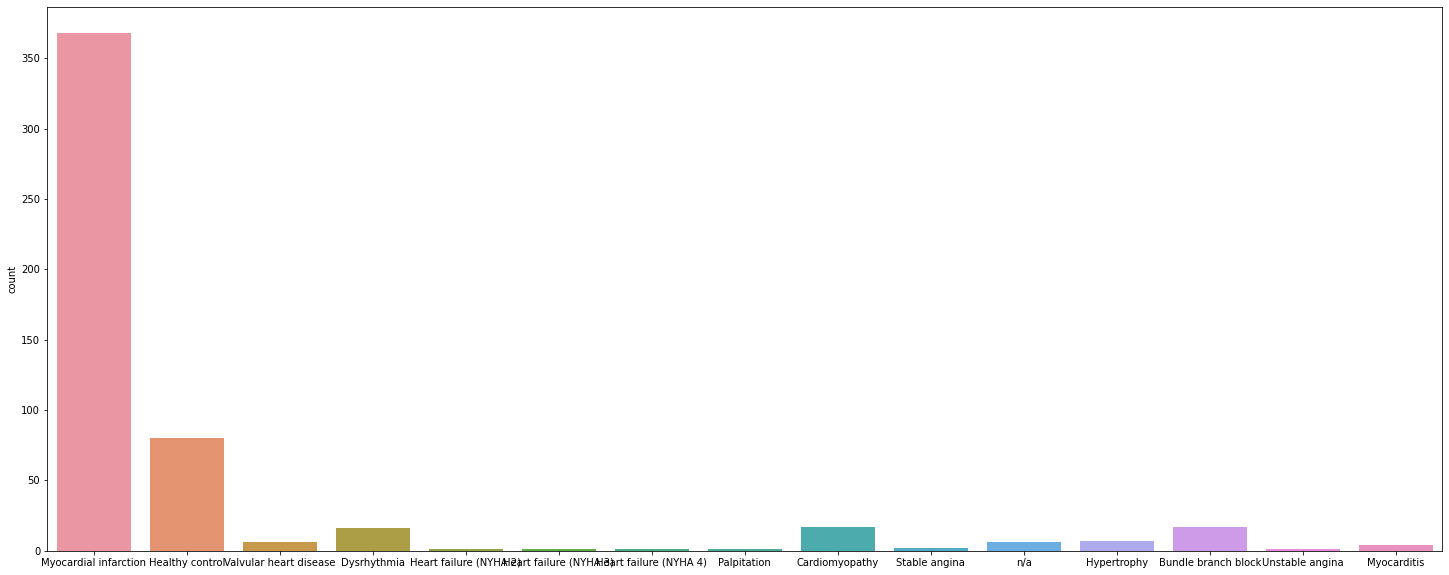

In [30]:
# Visualizing the distribution of classes
labels = []
for rec in records:
    data = wfdb.rdsamp(rec)
    label = " ".join(data[1]['comments'][4].split()[3:])
    labels.append(label)

plt.figure(figsize=(25, 10))
sns.countplot(labels)

In [31]:
# Visualizing the distribution of classes
Age = []
Sex = []
for rec in records:
    data = wfdb.rdsamp(rec)
    _age = " ".join(data[1]['comments'][0].split()[1:])
    _sex = " ".join(data[1]['comments'][1].split()[1:])

    if  (_age == "n/a") or (_sex == "n/a"):
      records.remove(rec)
      continue

    Age.append(int(_age))
    Sex.append(_sex)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


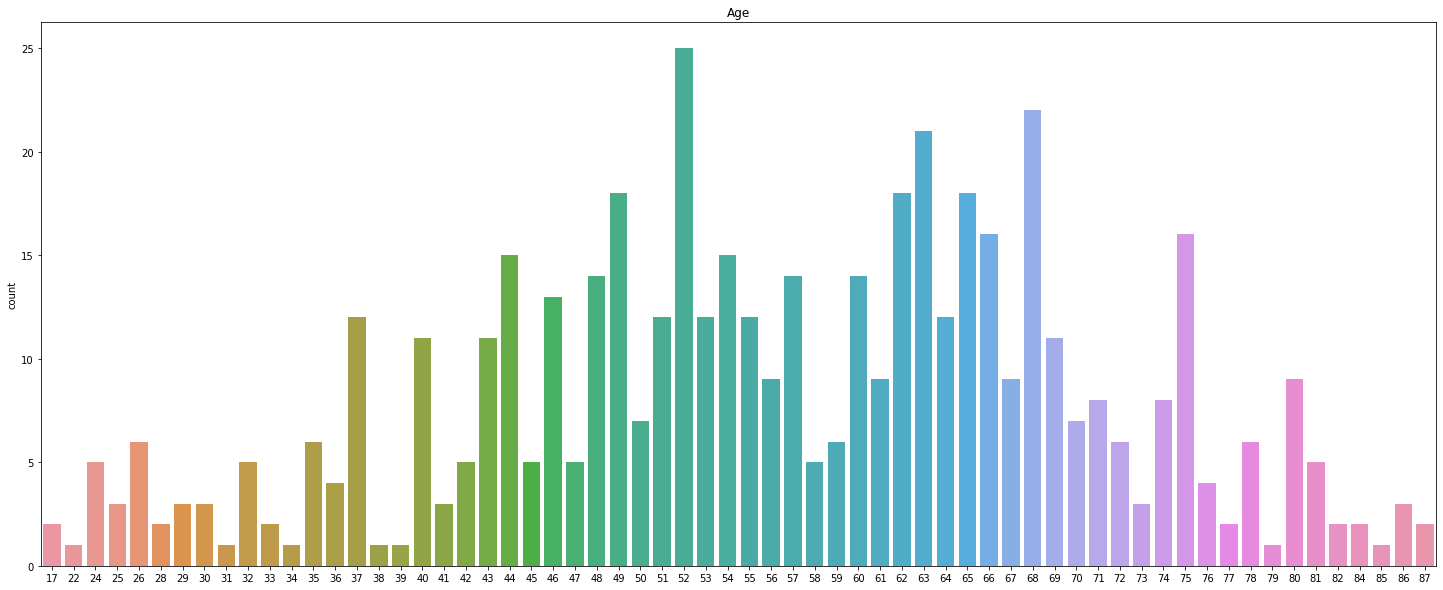

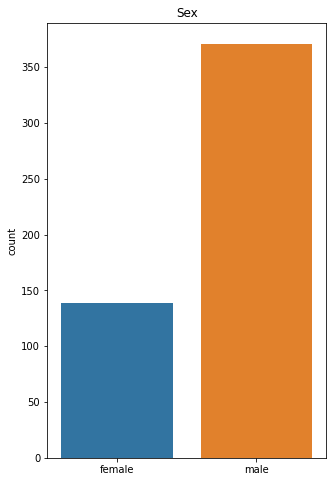

In [32]:
plt.figure(figsize=(25, 10))
plt.title("Age")
sns.countplot(Age)

plt.figure(figsize=(5, 8))
plt.title("Sex")
sns.countplot(Sex)

Data Cleaning
---

In [6]:
# Removing data with n/a labels
for rec in records:
    data = wfdb.rdsamp(rec)
    label = " ".join(data[1]['comments'][4].split()[3:])
    if label == "n/a":
        records.remove(rec)

# Preprocessing
---

## Denoising

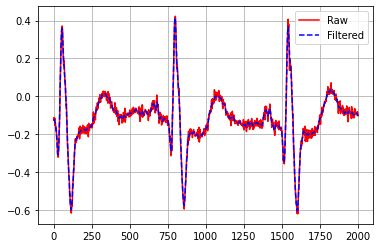

In [7]:
# IIR Filtering
def iir_lp(x, cutoff, fs):
    sos = signal.butter(4, 2*cutoff/fs, output='sos')
    y = signal.sosfiltfilt(sos, x)
    return y

data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re", channel_names=['i', 'ii'])[0]

plt.plot(data[:, 0][5000:7000], 'r')
plt.plot(iir_lp(data[:, 0][5000:7000], 50, 1000), 'b--')
plt.grid("on")
plt.legend(["Raw", "Filtered"])

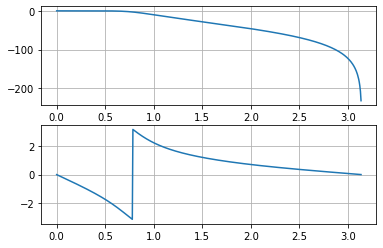

In [8]:
# Frequency response of IIR filter
b, a = signal.butter(4, 0.25, output='ba')
w, h = signal.freqz(b, a)
fig, ax = plt.subplots(2, 1)
ax[0].plot(w, 20*np.log10(np.abs(h)))
ax[0].grid("on")
ax[1].plot(w, np.angle(h))
ax[1].grid("on")

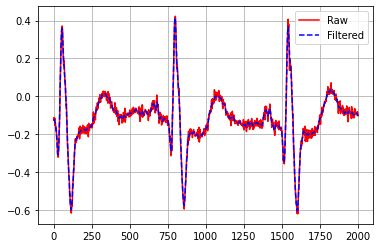

In [9]:
# FIR Filtering 
def fir_lp(x, cutoff, fs):
    h = signal.firwin(255, cutoff, fs=fs)
    y = signal.filtfilt(h, 1, x)
    return y

plt.plot(data[:, 0][5000:7000], 'r')
plt.plot(iir_lp(data[:, 0][5000:7000], 50, 1000), 'b--')
plt.grid("on")
plt.legend(["Raw", "Filtered"])

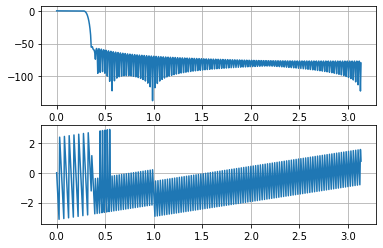

In [10]:
# Frequency response of FIR filter
h = signal.firwin(255, 50, fs=1000)
w, h = signal.freqz(h , 1)
fig, ax = plt.subplots(2, 1)
ax[0].plot(w, 20*np.log10(np.abs(h)))
ax[0].grid("on")
ax[1].plot(w, np.angle(h))
ax[1].grid("on")

Dimensionality Reduction
---

In [11]:
# PCA
data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re")[0]

pca = PCA(n_components=0.95)
pca_signal = pca.fit_transform(data)
print(f"Initial dimensions: {data.shape[1]} | Dimension after PCA: {pca_signal.shape[1]}")

Initial dimensions: 15 | Dimension after PCA: 4


In [12]:
def preprocess(x):
    pca = PCA(n_components=10)
    x_pca = pca.fit_transform(x)
    x_filtered = iir_lp(x_pca.T, 50, 1000)
    return x_filtered

data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re")[0]
preprocess(data).shape

(10, 38400)

In [13]:
def display_training_curves(training, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    # ax.legend(['train', 'valid.'])

# Train
---

In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, patients_list,
                 batch_size,
                 input_size=(10, 1000, 1),
                 shuffle=True):
        
        self.data_dir = data_dir
        self.patients_list = patients_list
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.patients_list)
        self.__get_recs()
    
    def __get_recs(self,):
        self.records = []
        for patient in self.patients_list:
            dir = Path(self.data_dir) / f"patient{str(patient).zfill(3)}"
            self.records.extend([dir / x[:-4] for x in glob(f"{str(dir)}/*.dat")])
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.records)
    
    def __getitem__(self, index):
        rec = self.records[index]
        signals = preprocess(wfdb.rdsamp(rec)[0])
        if signals.shape[1] < self.batch_size*1000:
            np.pad(signals, ((0, 0),(0, self.batch_size*1000 - signals.shape[1])), 'constant')

        batched_signals = np.array([signals[:, i*1000:(i+1)*1000] for i in range(self.batch_size)])
        labels = " ".join(wfdb.rdsamp(rec)[1]['comments'][4].split()[3:])
        return (batched_signals.reshape(self.batch_size, *self.input_size),
                (np.array(labels) == 'Myocardial infarction').astype(int).repeat(self.batch_size))
    
    def __len__(self):
        return self.n

In [15]:
# Splitting data into train, test, validation
NUM_SUBJECTS = 294
train_patients = np.random.choice(np.arange(1, NUM_SUBJECTS+1), int(0.8*NUM_SUBJECTS), replace=False)
test_patients = np.array([idx for idx in np.arange(1, NUM_SUBJECTS+1) if idx not in train_patients])

# Generators
train_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", train_patients, 32)
test_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", test_patients, 32)

In [16]:
# Splitting data into train, test, validation
test_patients = np.array([idx for idx in np.arange(1, NUM_SUBJECTS+1) if idx not in train_patients])
validation_patients = np.random.choice(test_patients, int(0.8*len(test_patients)), replace=False)
test_patients = np.array([i for i in test_patients if i not in validation_patients])

# Generators
train_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", train_patients, 32)
test_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", test_patients, 1)
validation_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", validation_patients, 32)

In [17]:
# len_generator = 446
print(train_gen[0][0].shape)
print(train_gen[0][1].shape)
print(train_gen[2][0].shape)

(32, 10, 1000, 1)
(32,)
(32, 10, 1000, 1)


# TA's Network

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, 3, activation="relu", input_shape=(10, 1000, 1)))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 998, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 499, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 63872)             0         
                                                                 
 dense (Dense)               (None, 10)                638730    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 639,061
Trainable params: 639,061
Non-trainable params: 0
__________________________________________________

In [ ]:
from keras.losses import BinaryCrossentropy

model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_gen, epochs=5)

Epoch 1/5
235/235 [==============================] - 643s 3s/step - loss: 0.6939 - accuracy: 0.6383
Epoch 2/5
235/235 [==============================] - 344s 1s/step - loss: 0.6801 - accuracy: 0.6511
Epoch 3/5
235/235 [==============================] - 214s 911ms/step - loss: 0.6776 - accuracy: 0.6255
Epoch 4/5
235/235 [==============================] - 174s 742ms/step - loss: 0.6715 - accuracy: 0.6383
Epoch 5/5
235/235 [==============================] - 136s 579ms/step - loss: 0.6637 - accuracy: 0.6553


# Residual Network

In [18]:
from keras import layers
from keras.losses import BinaryCrossentropy

input_s = layers.Input((10,1000,1))

base_res = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                         weights=None,  
                                         input_tensor = input_s)
pretrained_model_res = tf.keras.Model(inputs=base_res.input, outputs=base_res.layers[30].output)

model_res = keras.Sequential([
    pretrained_model_res,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
    # tf.keras.layers.Dense(1, activation="softmax")
])


model_res.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])

model_res.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 3, 250, 64)        168640    
                                                                 
 flatten (Flatten)           (None, 48000)             0         
                                                                 
 dense (Dense)               (None, 1)                 48001     
                                                                 
Total params: 216,641
Trainable params: 214,337
Non-trainable params: 2,304
_________________________________________________________________


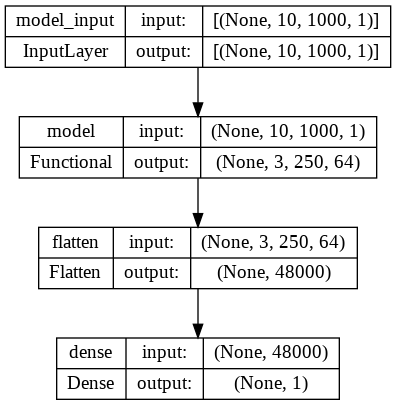

In [19]:
tf.keras.utils.plot_model(model_res, show_shapes=True)

In [20]:
history_res = model_res.fit(train_gen, epochs=5)

Epoch 1/5
235/235 [==============================] - 453s 2s/step - loss: 3.4073 - accuracy: 0.5604
Epoch 2/5
235/235 [==============================] - 451s 2s/step - loss: 2.2402 - accuracy: 0.5743
Epoch 3/5
235/235 [==============================] - 455s 2s/step - loss: 1.6934 - accuracy: 0.5864
Epoch 4/5
235/235 [==============================] - 447s 2s/step - loss: 1.7618 - accuracy: 0.5824
Epoch 5/5
235/235 [==============================] - 444s 2s/step - loss: 1.5274 - accuracy: 0.5773


In [21]:
model_res.evaluate(validation_gen)

47/47 [==============================] - 49s 1s/step - loss: 2.3182 - accuracy: 0.2773


[2.3181557655334473, 0.2772606313228607]

In [22]:
res_predicted = model_res.predict(test_gen)

12/12 [==============================] - 8s 633ms/step


In [23]:
lst = []
for i in range(len(test_gen)):
  lst.append(test_gen[i][1])

test_acc = np.mean( (lst - res_predicted) ** 2 )
print(f'resnet test accuracy = {1 - test_acc}')

resnet test accuracy = 0.688210347124707


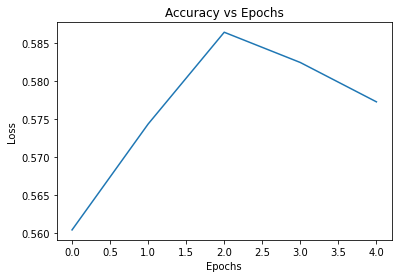

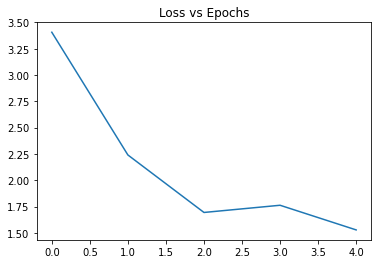

In [24]:
frame = pd.DataFrame(history_res.history)
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plt = acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

loss_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
loss_plt = acc_plot.set(xlabel="Epochs", ylabel="Loss")

In [25]:
from keras import layers
from keras.losses import BinaryCrossentropy

input_s = layers.Input((10,1000,1))

base_res = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                         weights=None,  
                                         input_tensor = input_s)
pretrained_model_res = tf.keras.Model(inputs=base_res.input, outputs=base_res.layers[30].output)

model_res = keras.Sequential([
    pretrained_model_res,
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(1, activation="sigmoid")
    tf.keras.layers.Dense(1, activation="softmax")
])


model_res.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])

model_res.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 3, 250, 64)        168640    
                                                                 
 flatten_1 (Flatten)         (None, 48000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 48001     
                                                                 
Total params: 216,641
Trainable params: 214,337
Non-trainable params: 2,304
_________________________________________________________________


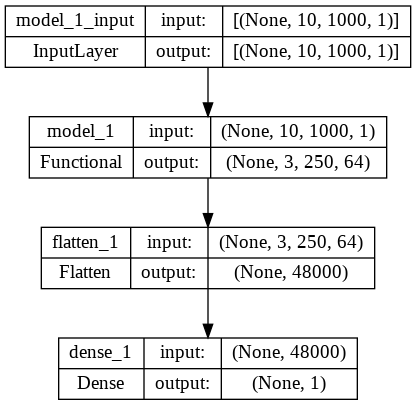

In [26]:
tf.keras.utils.plot_model(model_res, show_shapes=True)

In [27]:
history_res_soft = model_res.fit(train_gen, epochs=5)

Epoch 1/5
235/235 [==============================] - 450s 2s/step - loss: 3.4686 - accuracy: 0.6809
Epoch 2/5
235/235 [==============================] - 445s 2s/step - loss: 2.4724 - accuracy: 0.6255
Epoch 3/5
235/235 [==============================] - 458s 2s/step - loss: 1.9450 - accuracy: 0.6596
Epoch 4/5
235/235 [==============================] - 461s 2s/step - loss: 2.0368 - accuracy: 0.6638
Epoch 5/5
235/235 [==============================] - 446s 2s/step - loss: 1.5348 - accuracy: 0.6979


In [28]:
lst = []
for i in range(len(test_gen)):
  lst.append(test_gen[i][1])

test_acc = np.mean( (lst - res_predicted) ** 2 )
print(f'resnet test accuracy = {1 - test_acc}')


resnet test accuracy = 0.688210347124707


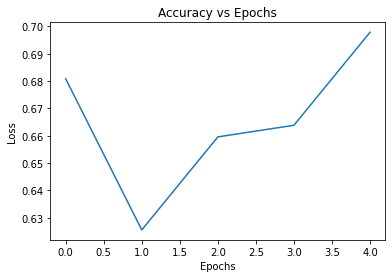

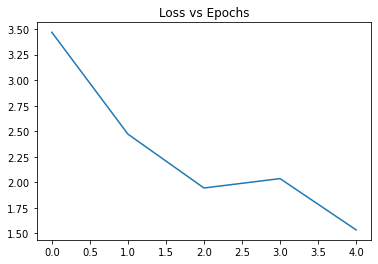

In [29]:
frame = pd.DataFrame(history_res_soft.history)
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plt = acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

loss_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
loss_plt = acc_plot.set(xlabel="Epochs", ylabel="Loss")

# Efficientnet Network

In [ ]:
from keras import layers
input_s = layers.Input((10,1000,1))

base_effB7 = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False,
                                         weights=None,  
                                         input_tensor = input_s)
pretrained_model_effB7 = tf.keras.Model(inputs=base_effB7.input, outputs=base_effB7.layers[100].output)


model_effB7 = keras.Sequential([
    pretrained_model_effB7,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="softmax")
])


model_effB7.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model_effB7.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_11 (Functional)       (None, 3, 250, 288)       131883    
                                                                 
 flatten_12 (Flatten)        (None, 216000)            0         
                                                                 
 dense_13 (Dense)            (None, 1)                 216001    
                                                                 
Total params: 347,884
Trainable params: 343,241
Non-trainable params: 4,643
_________________________________________________________________


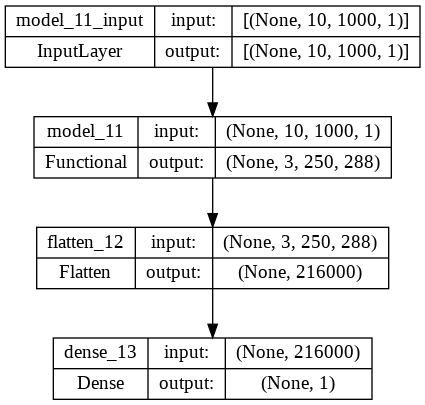

In [ ]:
tf.keras.utils.plot_model(model_effB7, show_shapes=True)

In [ ]:
history_Eff = model_effB7.fit_generator(train_gen, epochs=5)

<ipython-input-52-76a1cfb0f7e0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_Eff = model_effB7.fit_generator(train_gen, epochs=5)


Epoch 1/5
235/235 [==============================] - 978s 4s/step - loss: 6.8820 - accuracy: 0.6851
Epoch 2/5
235/235 [==============================] - 969s 4s/step - loss: 1.7832 - accuracy: 0.6766
Epoch 3/5
235/235 [==============================] - 987s 4s/step - loss: 0.8864 - accuracy: 0.6936
Epoch 4/5
235/235 [==============================] - 973s 4s/step - loss: 0.9288 - accuracy: 0.6723
Epoch 5/5
235/235 [==============================] - 978s 4s/step - loss: 0.6374 - accuracy: 0.6809


In [ ]:
model_effB7.evaluate(validation_gen)

47/47 [==============================] - 78s 2s/step - loss: 1.2220 - accuracy: 0.6596


[1.2220107316970825, 0.6595744490623474]

In [ ]:
Eff_predicted = model_effB7.predict(test_gen)

12/12 [==============================] - 15s 1s/step


In [ ]:
lst = []
for i in range(len(test_gen)):
  lst.append(test_gen[i][1])

test_acc = np.mean( (lst - Eff_predicted) ** 2 )
print(f'EfficientNet B7 test accuracy = {1 - test_acc}')

EfficientNet B7 test accuracy = 0.75


In [ ]:
def display_training_curves(training, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    # ax.legend(['train', 'valid.'])

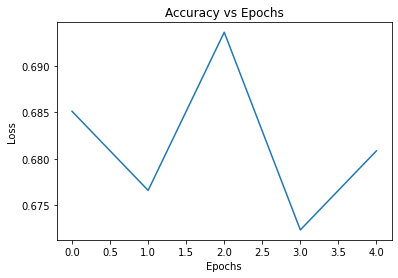

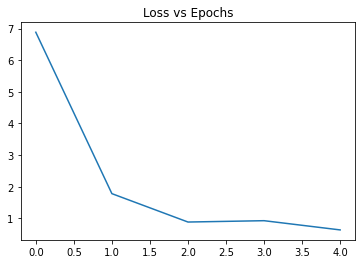

In [ ]:
frame = pd.DataFrame(history_Eff.history)
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plt = acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

loss_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
loss_plt = acc_plot.set(xlabel="Epochs", ylabel="Loss")

# Custom VGG

In [ ]:
model_VGG = tf.keras.Sequential()

# VGG_1
model_VGG.add(tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(10, 1000, 1)))
model_VGG.add(tf.keras.layers.BatchNormalization())
model_VGG.add(tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(10, 1000, 1)))
model_VGG.add(tf.keras.layers.BatchNormalization())
model_VGG.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_VGG.add(tf.keras.layers.Dropout(0.2))

# VGG_2
model_VGG.add(tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(10, 1000, 1)))
model_VGG.add(tf.keras.layers.BatchNormalization())
model_VGG.add(tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(10, 1000, 1)))
model_VGG.add(tf.keras.layers.BatchNormalization())
model_VGG.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_VGG.add(tf.keras.layers.Dropout(0.3))

# VGG_3
model_VGG.add(tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(10, 1000, 1)))
model_VGG.add(tf.keras.layers.BatchNormalization())
model_VGG.add(tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(10, 1000, 1)))
model_VGG.add(tf.keras.layers.BatchNormalization())
model_VGG.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_VGG.add(tf.keras.layers.Dropout(0.4))

# Output
model_VGG.add(tf.keras.layers.Flatten())
model_VGG.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_VGG.add(tf.keras.layers.BatchNormalization())
model_VGG.add(tf.keras.layers.Dropout(0.5))
model_VGG.add(tf.keras.layers.Dense(1, activation='softmax'))

In [ ]:
model_VGG.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model_VGG.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 1000, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 10, 1000, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 1000, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 1000, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 500, 32)       0         
 )                                                               
                                                     

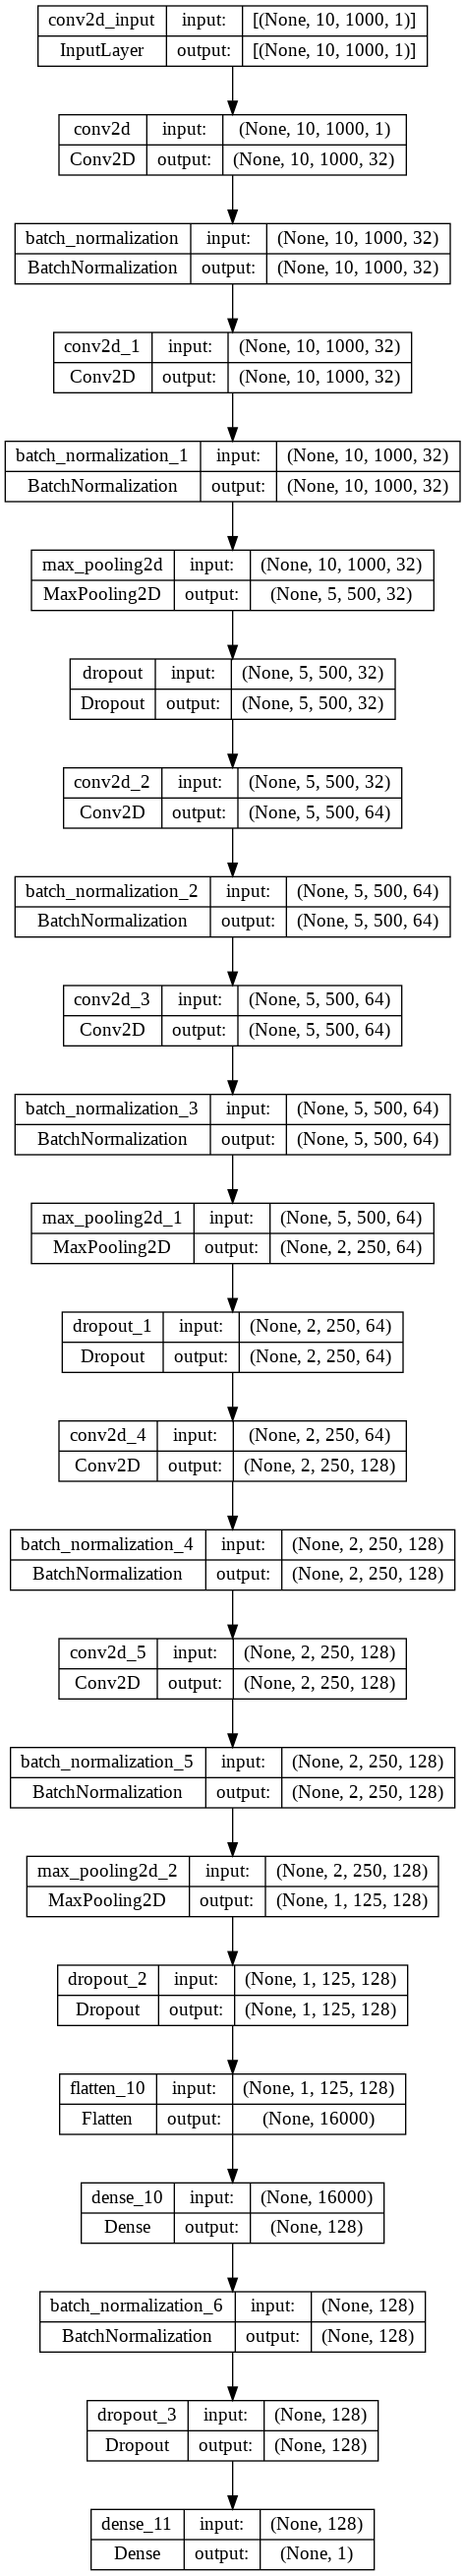

In [ ]:
tf.keras.utils.plot_model(model_VGG, show_shapes=True)

In [ ]:
history_VGG = model_VGG.fit(train_gen, epochs=5)

Epoch 1/5
235/235 [==============================] - 791s 3s/step - loss: 0.8066 - accuracy: 0.6723
Epoch 2/5
235/235 [==============================] - 759s 3s/step - loss: 0.6657 - accuracy: 0.7021
Epoch 3/5
235/235 [==============================] - 767s 3s/step - loss: 0.6622 - accuracy: 0.6723
Epoch 4/5
235/235 [==============================] - 776s 3s/step - loss: 0.6429 - accuracy: 0.6809
Epoch 5/5
235/235 [==============================] - 770s 3s/step - loss: 0.6464 - accuracy: 0.6766


In [ ]:
model_VGG.evaluate(validation_gen)

47/47 [==============================] - 74s 2s/step - loss: 0.7339 - accuracy: 0.5319


[0.7339455485343933, 0.5319148898124695]

In [ ]:
VGG_predicted = model_VGG.predict(test_gen)

12/12 [==============================] - 10s 691ms/step


In [ ]:
lst = []
for i in range(len(test_gen)):
  lst.append(test_gen[i][1])

test_acc = np.mean( (lst - VGG_predicted) ** 2 )
print(f'resnet test accuracy = {1 - test_acc}')

resnet test accuracy = 0.75


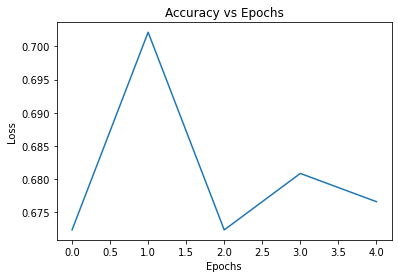

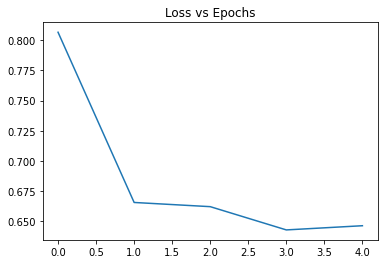

In [ ]:
frame = pd.DataFrame(history_VGG.history)
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plt = acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

loss_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
loss_plt = acc_plot.set(xlabel="Epochs", ylabel="Loss")